<a href="https://colab.research.google.com/github/Akhilesh-K-Yadav/GANs/blob/main/MNIST_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

In [55]:
# Confs:
DEVICE = 'cuda'
BATCH_SIZE = 128
NOISE_VEC_DIM = 64
LR = 0.0002
BETA1 = 0.5
BETA2 = 0.99
EPOCHS = 20 

In [56]:
from torchvision import datasets, transforms as T

In [57]:
augs = T.Compose([
    T.RandomRotation((-20, 20)),
    T.ToTensor() # also converts to the format of c,h,w 
])

In [58]:
trainset = datasets.MNIST('MNIST/', download= True, train= True, transform= augs)

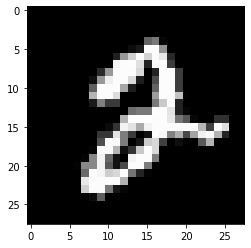

In [59]:
image, label = trainset[5]
plt.imshow(image.squeeze(), cmap='gray')

In [60]:
len(trainset)

60000

In [61]:
from torch.utils.data import DataLoader

In [62]:
from torchvision.utils import make_grid

In [63]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True)

In [64]:
len(trainloader)

469

In [65]:
data = iter(trainloader)
images, _ = data.next()
images.shape

torch.Size([128, 1, 28, 28])

In [66]:
def show_images(images, num_images=16, size=(1, 28, 28)):
  imgs = images.cpu().detach()
  imgs_grid = make_grid(imgs[0: num_images], nrow=4)
  plt.imshow(imgs_grid.permute(1, 2, 0).squeeze())
  plt.show()

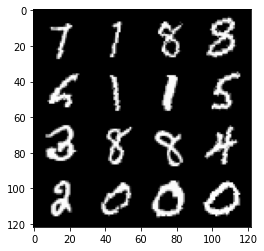

In [67]:
show_images(images)

In [68]:
#Discriminator:
from torch import nn
from torchsummary import summary

In [69]:
from torch.nn.modules.activation import LeakyReLU
def get_dis_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [70]:
class DisNet(nn.Module):
  def __init__(self):
    super(DisNet, self).__init__()

    self.block1 = get_dis_block(1, 16, (3, 3), 2)
    self.block2 = get_dis_block(16, 32, (5, 5), 2)
    self.block3 = get_dis_block(32, 64, (5, 5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features= 64, out_features= 1)

  def forward(self, imgs):
    x = self.block1(imgs)
    x = self.block2(x)
    x = self.block3(x)
    x = self.flatten(x)
    x = self.linear(x)
    return x

In [71]:
D = DisNet()
D.to(DEVICE)

DisNet(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [72]:
summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [73]:
#Generator:

def get_gen_block(in_channels, out_channels, kernel_size, stride, is_last=False):
  if is_last:
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.Tanh()
    )
    
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [74]:
class GenNet(nn.Module):
  def __init__(self, noise_dim):
    super(GenNet, self).__init__()

    self.noise_dim = noise_dim
    self.block1 = get_gen_block(self.noise_dim, 256, (3, 3), 2)
    self.block2 = get_gen_block(256, 128, (4, 4), 1)
    self.block3 = get_gen_block(128, 64, (3, 3), 2)
    self.block4 = get_gen_block(64, 1, (4, 4), 2, is_last=True)

  def forward(self, noise_vec):
    x = noise_vec.view(-1, self.noise_dim, 1, 1)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)

    return x

In [75]:
G = GenNet(NOISE_VEC_DIM)
G.to(DEVICE)

GenNet(
  (block1): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)

In [76]:
summary(G, input_size=(1, NOISE_VEC_DIM))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [77]:
#Replace random init weights with Normal weights:
def init_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    nn.init.normal_(m.weight, 0.0, 0.2)
  if isinstance(m, nn.BatchNorm2d):
    nn.init.normal_(m.weight, 0.0, 0.2)
    nn.init.constant_(m.bias, 0)

In [78]:
D = D.apply(init_weights)
G = G.apply(init_weights)

In [79]:
from torch.nn.modules import distance
# Losses:

def loss_real(dis_preds):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(dis_preds)
  loss = criterion(dis_preds, ground_truth)
  return loss

def loss_fake(dis_preds):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(dis_preds)
  loss = criterion(dis_preds, ground_truth)
  return loss

In [80]:
#Optimizers:
D_optim = torch.optim.Adam(D.parameters(), lr=LR, betas=(BETA1, BETA2))
G_optim = torch.optim.Adam(G.parameters(), lr=LR, betas=(BETA1, BETA2))

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 1 D_loss: 0.6921428480127981 G_loss: 0.6941811532608227


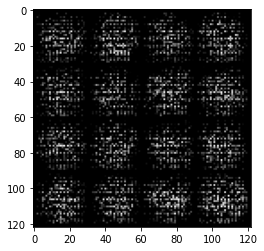

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 2 D_loss: 0.6836923036748158 G_loss: 0.7046082562475062


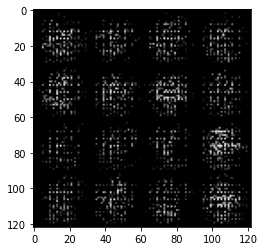

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 3 D_loss: 0.6648082330282817 G_loss: 0.7257451218074319


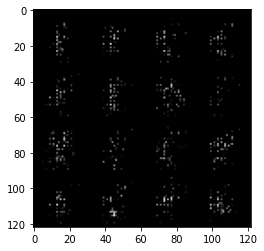

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 4 D_loss: 0.6465119828801673 G_loss: 0.7466246058691793


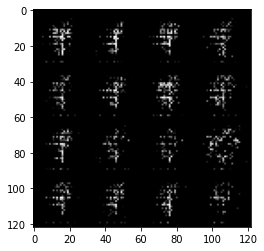

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 5 D_loss: 0.6253204847703865 G_loss: 0.7756435196282767


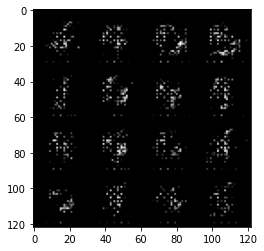

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 6 D_loss: 0.6054131124319553 G_loss: 0.810999546350955


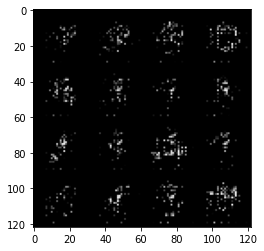

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 7 D_loss: 0.5850865579108948 G_loss: 0.845512196707573


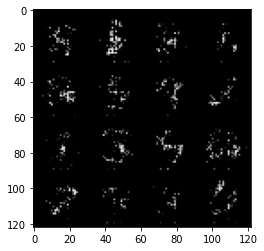

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 8 D_loss: 0.5751418703908859 G_loss: 0.8711413213693256


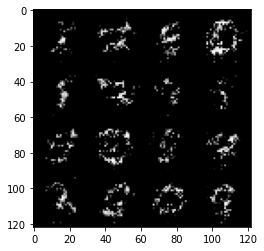

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 9 D_loss: 0.5718081385087865 G_loss: 0.8884492683003961


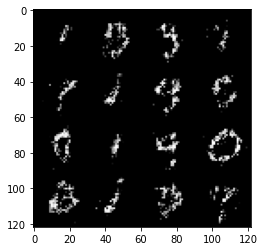

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 10 D_loss: 0.5656752072926015 G_loss: 0.9047183544396846


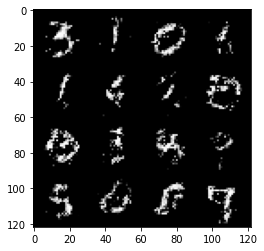

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 11 D_loss: 0.5659679006666009 G_loss: 0.9142728890183129


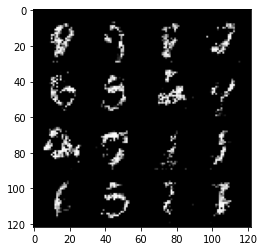

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 12 D_loss: 0.5697193491433475 G_loss: 0.9189833205646035


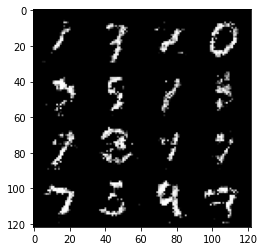

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 13 D_loss: 0.5748532807140716 G_loss: 0.9157806040127394


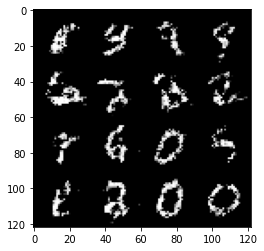

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 14 D_loss: 0.5770958543840502 G_loss: 0.9180168819579997


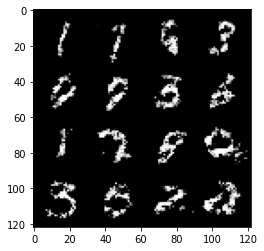

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 15 D_loss: 0.5798167700706515 G_loss: 0.9197781390981126


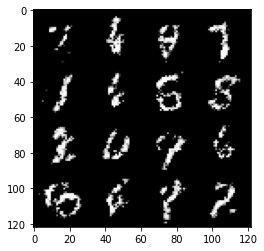

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 16 D_loss: 0.5805155247259242 G_loss: 0.922900420262107


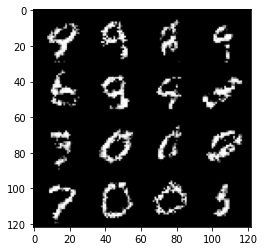

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 17 D_loss: 0.5817289107135618 G_loss: 0.9276695607313469


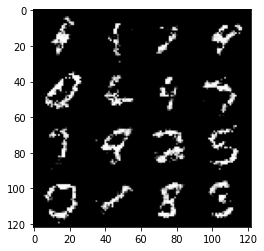

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 18 D_loss: 0.5803572330901872 G_loss: 0.9308737536737406


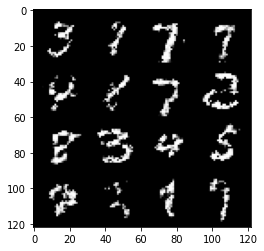

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 19 D_loss: 0.5808239759666833 G_loss: 0.9367836416403114


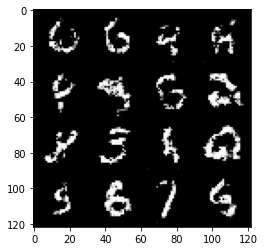

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 20 D_loss: 0.5801060461540466 G_loss: 0.9353276383139686


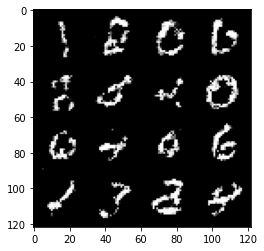

In [81]:
#Training:

for i in range(EPOCHS):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_imgs, _ in tqdm(trainloader):
    real_imgs = real_imgs.to(DEVICE)
    noise = torch.randn(BATCH_SIZE, NOISE_VEC_DIM, device= DEVICE)

    D_optim.zero_grad()

    fake_imgs = G(noise)
    d_preds = D(fake_imgs)
    d_loss_fake = loss_fake(d_preds)

    d_preds = D(real_imgs)
    d_loss_real = loss_real(d_preds)

    d_loss = (d_loss_fake + d_loss_real) / 2
    total_d_loss += d_loss.item()
    d_loss.backward()
    D_optim.step()

    noise = torch.randn(BATCH_SIZE, NOISE_VEC_DIM, device= DEVICE)

    G_optim.zero_grad()

    fake_imgs = G(noise)
    d_preds = D(fake_imgs)
    g_loss = loss_real(d_preds)
    total_g_loss += g_loss.item()

    g_loss.backward()
    G_optim.step()

  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/len(trainloader)
  print(f"Epochs: {i+1} D_loss: {avg_d_loss} G_loss: {avg_g_loss}")
  show_images(fake_imgs)
